# Portfolio Metrics Verification Notebook
This notebook allows you to visualize and manually verify all portfolio metrics calculations.
It filters for **current holdings only** and displays all data points used in calculations.

In [3]:
import sys
import os
import pandas as pd
import numpy as np
import json
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# Setup path
backend_path = Path(r'c:/Users/Dhruv/Desktop/Portfolio_Updated/portfolio-/backend')
sys.path.insert(0, str(backend_path))

from metrics.beta import BetaCalculator
from metrics.ratios import RatioCalculator
from metrics.alpha import AlphaCalculator
from orchestrator import Orchestrator  # <-- Import the CLASS

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.6f}'.format)

# Seaborn style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

## 1. Load Portfolio Data
Specify your transaction file path here:

In [11]:
# UPDATE THIS PATH to your transaction file
transaction_file = r"C:\Users\Dhruv\Downloads\ZERODHA-tradebook-2025-EQ.xlsx"

# Create orchestrator instance
orchestrator = Orchestrator()

# Run orchestration
print("Loading portfolio data...")
full_response = orchestrator.process_portfolio(file_path=transaction_file)

# Extract current holdings from the ledger
current_holdings = full_response.get('ledger', {}).get('current_holdings', [])

print(f"\n✓ Portfolio loaded successfully!")
print(f"  Total current holdings: {len(current_holdings)}")

# Display current holdings
holdings_df = pd.DataFrame(current_holdings)
if not holdings_df.empty:
    if 'Current_Value' in holdings_df.columns:
        holdings_df = holdings_df.sort_values('Current_Value', ascending=False)
        display(holdings_df[['Symbol', 'Qty', 'Mkt_Price', 'Current_Value']])

# Create normalized portfolio for metrics - CORRECTED
print("\n" + "="*80)
print("Creating normalized portfolio structure...")
print("="*80)

normalized_portfolio = {'current_holdings': []}

for holding in current_holdings:
    if len(normalized_portfolio['current_holdings']) == 0:
        print(f"\nAvailable columns: {list(holding.keys())}")
    
    normalized_portfolio['current_holdings'].append({
        'symbol': holding.get('scrip'),           # ← 'scrip' not 'Symbol'
        'quantity': holding.get('qty', 0),        # ← 'qty' not 'Qty'
        'current_price': holding.get('current_price', 0)
    })

print(f"\n✓ Normalized portfolio created with {len(normalized_portfolio['current_holdings'])} holdings")
if normalized_portfolio['current_holdings']:
    sample = normalized_portfolio['current_holdings'][0]
    print(f"Sample: {sample}")

Loading portfolio data...
DEBUG SCAN Row 0: ['nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan']
DEBUG SCAN Row 1: ['nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan']
DEBUG SCAN Row 2: ['nan', "view zerodha's guide on using tax reports for filing.", 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan']
DEBUG SCAN Row 3: ['nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan']
DEBUG SCAN Row 4: ['nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan']
DEBUG Row 13 has 6 matches.
Found Generic header at row 13 with 6 matches: ['nan', 'symbol', 'isin', 'trade date', 'exchange', 'segment', 'series', 'trade type', 'auction', 'quantity', 'price', 'trade id', 'order id', 'order execution time']
DEBUG: enrich_trade_data called. DB_AVAILABLE=True, df_shape=(66, 16)


c:\Users\Dhruv\Desktop\Portfolio_Updated\portfolio-\backend\mtm\repo\price_action.py:112: UserWarning:

Missing fundamental data for symbols: ['GOLDBEESE']

c:\Users\Dhruv\Desktop\Portfolio_Updated\portfolio-\backend\mtm\repo\price_action.py:114: UserWarning:

Missing price action data for symbols: ['AUTOBEES', 'BANKBEES', 'GOLDBEESE', 'ITBEES', 'NIFTYBEES']

c:\Users\Dhruv\Desktop\Portfolio_Updated\portfolio-\backend\mtm\repo\price_action.py:114: UserWarning:

Missing price action data for symbols: ['BANKBEES']

c:\Users\Dhruv\Desktop\Portfolio_Updated\portfolio-\backend\mtm\repo\price_action.py:112: UserWarning:

Missing fundamental data for symbols: ['GOLDBEESE']

c:\Users\Dhruv\Desktop\Portfolio_Updated\portfolio-\backend\mtm\repo\price_action.py:114: UserWarning:

Missing price action data for symbols: ['AUTOBEES', 'BANKBEES', 'GOLDBEESE', 'ITBEES', 'NIFTYBEES']




✓ Portfolio loaded successfully!
  Total current holdings: 1

Creating normalized portfolio structure...

Available columns: ['id', 'scrip', 'type', 'qty', 'date', 'price', 'current_price', 'buy_brokerage', 'buy_taxes', 'tax_breakdown', 'pnl_perc', 'status']

✓ Normalized portfolio created with 1 holdings
Sample: {'symbol': 'JINDALSAW', 'quantity': 42, 'current_price': 171.5}


## 2. Calculate Beta with Full Debug Data
This section shows beta calculations with **ALL data points** used.

In [12]:
print("Calculating Beta for all current holdings...\n")

beta_calc = BetaCalculator(benchmark_symbol="Nifty 50", lookback_days=730)
beta_results = beta_calc.calculate_portfolio_beta(normalized_portfolio)

# Extract daily betas
daily_betas = beta_results.get('daily_betas', {}).get('individual', {})
monthly_betas = beta_results.get('monthly_betas', {}).get('individual', {})

print(f"Portfolio Beta (Daily): {beta_results['daily_betas']['portfolio_beta']}")
print(f"Portfolio Beta (Monthly): {beta_results['monthly_betas']['portfolio_beta']}\n")

# Save results for later use
with open('beta_debug_output.json', 'w') as f:
    json.dump(beta_results, f, indent=2)
print("✓ Beta results saved to 'beta_debug_output.json'")

Calculating Beta for all current holdings...

Portfolio Beta (Daily): 1.7774
Portfolio Beta (Monthly): 2.5371

✓ Beta results saved to 'beta_debug_output.json'


### 2.1 Examine Beta for Individual Stock
Pick a stock and see ALL data points used in variance/covariance:

Examining Beta Calculation for: JINDALSAW

BETA CALCULATION SUMMARY - JINDALSAW
Beta Value: 1.7774
Covariance: 0.00011758
Market Variance: 6.615e-05
Correlation: 0.4048
Data Points: 496
Period: 2024-01-08 to 2026-01-06


DEBUG DATA AVAILABLE:
  Mean Stock Return: -0.00124527
  Mean Market Return: 0.00042892
  Stock Variance: 0.00127557
  Market Variance: 6.615e-05

First 10 data points:


,Stock_Return,Market_Return
Date,,
2024-01-09,0.021762,0.001481
2024-01-10,0.029547,0.003428
2024-01-11,-0.006490,0.001318
2024-01-12,-0.002450,0.011426
2024-01-15,0.053924,0.009267
2024-01-16,0.008058,-0.002948
2024-01-17,0.001926,-0.020894
2024-01-18,-0.027396,-0.005085
2024-01-19,0.003459,0.007462



Last 10 data points:


,Stock_Return,Market_Return
Date,,
2025-12-23,0.027917,0.000181
2025-12-24,-0.011029,-0.001339
2025-12-26,-0.003957,-0.003818
2025-12-29,-0.005478,-0.003848
2025-12-30,-0.002663,-0.000125
2025-12-31,0.019239,0.007354
2026-01-01,-0.002858,0.000649
2026-01-02,0.018631,0.006961
2026-01-05,0.012370,-0.002972



MANUAL VERIFICATION
Manual Covariance: 0.00011758 (Expected: 0.00011758)
Manual Market Variance: 0.00006615 (Expected: 6.615e-05)
Manual Beta: 1.7774 (Expected: 1.7774)

Match: True


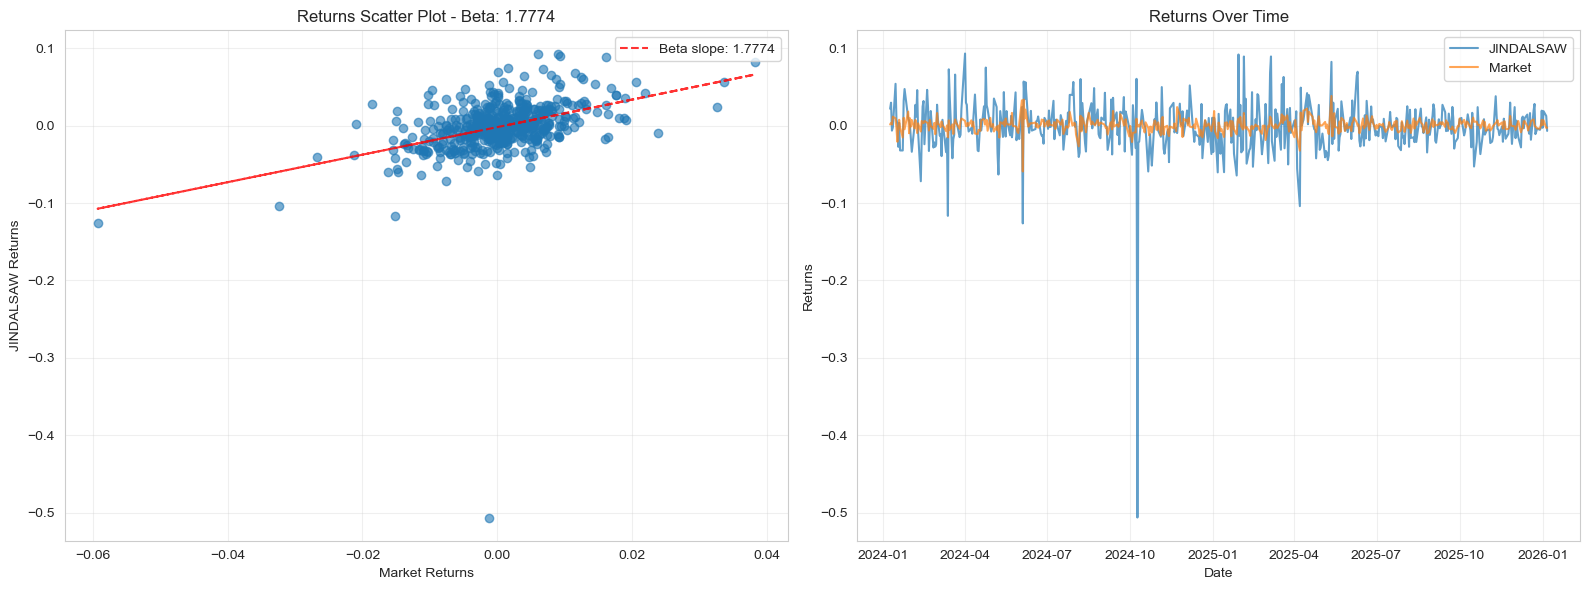

In [15]:
# Select first stock from current holdings
if current_holdings:
    sample_symbol = current_holdings[0]['scrip']
    print(f"Examining Beta Calculation for: {sample_symbol}\n")
    
    if sample_symbol in daily_betas:
        beta_data = daily_betas[sample_symbol]
        
        # Display summary
        print("=" * 80)
        print(f"BETA CALCULATION SUMMARY - {sample_symbol}")
        print("=" * 80)
        print(f"Beta Value: {beta_data['beta']}")
        print(f"Covariance: {beta_data['covariance']}")
        print(f"Market Variance: {beta_data['market_variance']}")
        print(f"Correlation: {beta_data['correlation']}")
        print(f"Data Points: {beta_data['data_points']}")
        print(f"Period: {beta_data['start_date']} to {beta_data['end_date']}")
        print("\n" + "=" * 80)
        
        # Extract debug data
        debug = beta_data.get('debug_data', {})
        if debug:
            print("\nDEBUG DATA AVAILABLE:")
            print(f"  Mean Stock Return: {debug['mean_stock_return']}")
            print(f"  Mean Market Return: {debug['mean_market_return']}")
            print(f"  Stock Variance: {debug['stock_variance']}")
            print(f"  Market Variance: {beta_data['market_variance']}")
            
            # Create DataFrame with all returns
            returns_df = pd.DataFrame({
                'Date': debug['dates'],
                'Stock_Return': debug['stock_returns'],
                'Market_Return': debug['market_returns']
            })
            returns_df['Date'] = pd.to_datetime(returns_df['Date'])
            returns_df = returns_df.set_index('Date')
            
            print(f"\nFirst 10 data points:")
            display(returns_df.head(10))
            print(f"\nLast 10 data points:")
            display(returns_df.tail(10))
            
            # Manual verification formulas
            print("\n" + "=" * 80)
            print("MANUAL VERIFICATION")
            print("=" * 80)
            manual_cov = returns_df['Stock_Return'].cov(returns_df['Market_Return'])
            manual_var = returns_df['Market_Return'].var()
            manual_beta = manual_cov / manual_var
            
            print(f"Manual Covariance: {manual_cov:.8f} (Expected: {beta_data['covariance']})")
            print(f"Manual Market Variance: {manual_var:.8f} (Expected: {beta_data['market_variance']})")
            print(f"Manual Beta: {manual_beta:.4f} (Expected: {beta_data['beta']})")
            print(f"\nMatch: {abs(manual_beta - beta_data['beta']) < 0.0001}")
            
            # Visualization
            fig, axes = plt.subplots(1, 2, figsize=(16, 6))
            
            # Scatter plot
            axes[0].scatter(returns_df['Market_Return'], returns_df['Stock_Return'], alpha=0.6)
            axes[0].set_xlabel('Market Returns')
            axes[0].set_ylabel(f'{sample_symbol} Returns')
            axes[0].set_title(f'Returns Scatter Plot - Beta: {beta_data["beta"]}')
            axes[0].grid(True, alpha=0.3)
            
            # Add regression line
            z = np.polyfit(returns_df['Market_Return'], returns_df['Stock_Return'], 1)
            p = np.poly1d(z)
            axes[0].plot(returns_df['Market_Return'], p(returns_df['Market_Return']), 
                        "r--", alpha=0.8, label=f'Beta slope: {z[0]:.4f}')
            axes[0].legend()
            
            # Time series
            axes[1].plot(returns_df.index, returns_df['Stock_Return'], label=sample_symbol, alpha=0.7)
            axes[1].plot(returns_df.index, returns_df['Market_Return'], label='Market', alpha=0.7)
            axes[1].set_xlabel('Date')
            axes[1].set_ylabel('Returns')
            axes[1].set_title('Returns Over Time')
            axes[1].legend()
            axes[1].grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
        else:
            print("⚠ No debug data available. Make sure you're using the updated beta.py")
    else:
        print(f"⚠ Beta data not available for {sample_symbol}")
else:
    print("No current holdings to examine")

## 3. Calculate Ratios with Full Debug Data
This shows Sharpe, Sortino, Information, and Treynor ratios with all data points.

In [16]:
print("Calculating Ratios for all current holdings...\n")

ratio_calc = RatioCalculator(benchmark_symbol="Nifty 50", risk_free_rate=0.0662)
ratio_results = ratio_calc.calculate_ratios(normalized_portfolio)

# Extract results
portfolio_metrics = ratio_results.get('portfolio_metrics', {})
individual_metrics = ratio_results.get('individual_metrics', {})

print("Portfolio Metrics:")
for key, value in portfolio_metrics.items():
    if key != 'debug_data':
        print(f"  {key}: {value}")

# Save results
with open('ratios_debug_output.json', 'w') as f:
    json.dump(ratio_results, f, indent=2)
print("\n✓ Ratio results saved to 'ratios_debug_output.json'")

Calculating Ratios for all current holdings...

Portfolio Metrics:
  sharpe_ratio: -1.0514
  sortino_ratio: -1.7458
  information_ratio: -1.3152
  treynor_ratio: -0.2134
  omega_ratio: 0.8365
  annual_return: -0.3778
  active_return: -0.4852
  annual_volatility: 0.4223
  downside_volatility: 0.2543
  tracking_error: 0.3689
  beta_calc: 2.0805
  hhi: 1.0

✓ Ratio results saved to 'ratios_debug_output.json'


### 3.1 Examine Ratios for Individual Stock
Deep dive into variance/covariance calculations for ratios:

Examining Ratio Calculations for: JINDALSAW

RATIO CALCULATION SUMMARY - JINDALSAW
Sharpe Ratio: -1.0514
Sortino Ratio: -1.7458
Information Ratio: -1.3152
Treynor Ratio: -0.2134
Omega Ratio: 0.8365

Annual Return: -0.3778
Annual Volatility: 0.4223
Downside Volatility: 0.2543
Beta: 2.0805


DEBUG DATA AVAILABLE:
  Mean Return: -0.00149922
  Variance: 0.00070761
  Covariance: 0.00011026
  Market Variance: 5.3e-05
  Downside Variance: 0.00025667

Total data points: 248
First 10 data points:


,Return,Benchmark_Return
Date,,
2025-01-08,-0.011236,-0.000799
2025-01-09,-0.036326,-0.006858
2025-01-10,-0.011019,-0.004038
2025-01-13,-0.060203,-0.014747
2025-01-14,0.018927,0.003903
2025-01-15,0.026128,0.001603
2025-01-16,0.027651,0.004248
2025-01-17,-0.000387,-0.004659
2025-01-20,0.020720,0.006100



Last 10 data points:


,Return,Benchmark_Return
Date,,
2025-12-23,0.027917,0.000181
2025-12-24,-0.011029,-0.001339
2025-12-26,-0.003957,-0.003818
2025-12-29,-0.005478,-0.003848
2025-12-30,-0.002663,-0.000125
2025-12-31,0.019239,0.007354
2026-01-01,-0.002858,0.000649
2026-01-02,0.018631,0.006961
2026-01-05,0.012370,-0.002972



Negative returns for Sortino calculation: 140 days
Sample negative returns: [-0.011236, -0.036326, -0.011019, -0.060203, -0.000387, -0.022197, -0.020179, -0.036064, -0.064457, -0.017388]

MANUAL VERIFICATION
Manual Variance: 0.00070761 (Expected: 0.00070761)
Match: True

Manual Covariance: 0.00011026 (Expected: 0.00011026)
Match: True

Manual Beta: 2.0805 (Expected: 2.0805)
Match: True

Manual Annual Volatility: 0.4223 (Expected: 0.4223)
Match: True

Manual Sharpe Ratio: -1.0514 (Expected: -1.0514)
Match: True


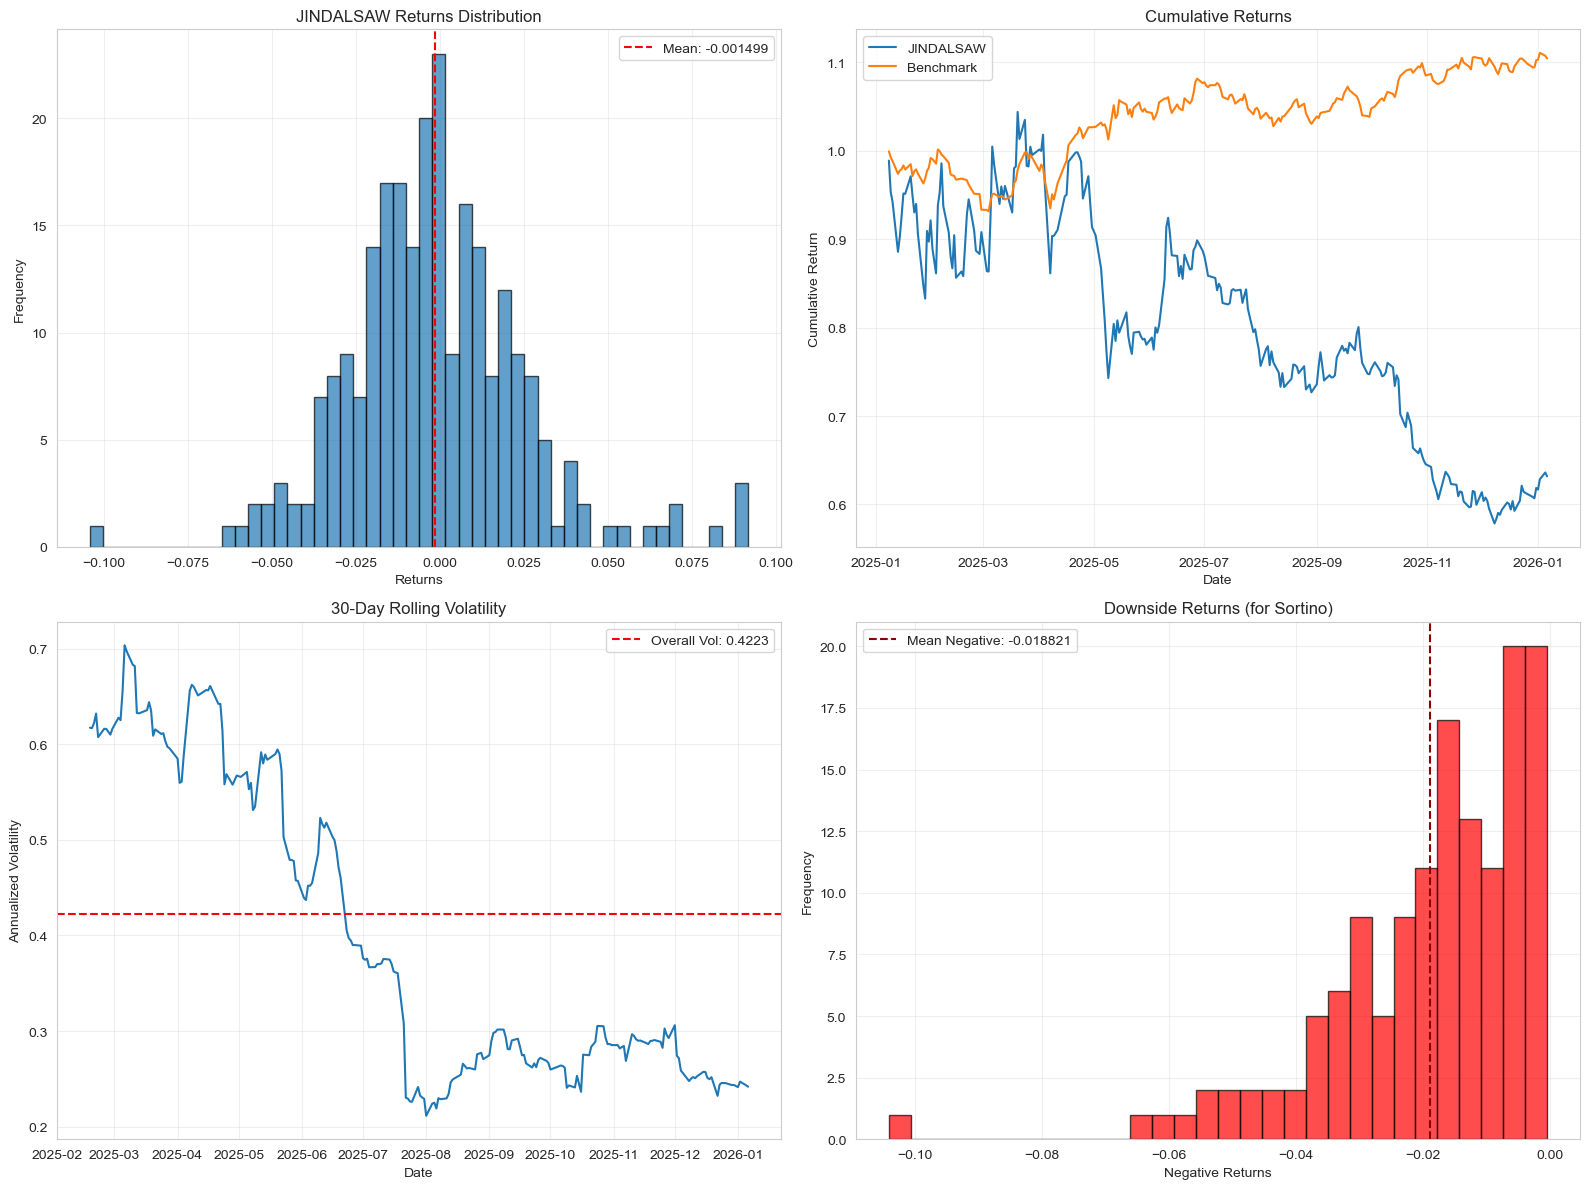

In [17]:
if current_holdings and individual_metrics:
    sample_symbol = current_holdings[0]['scrip']
    print(f"Examining Ratio Calculations for: {sample_symbol}\n")
    
    if sample_symbol in individual_metrics:
        metrics = individual_metrics[sample_symbol]
        
        # Display summary
        print("=" * 80)
        print(f"RATIO CALCULATION SUMMARY - {sample_symbol}")
        print("=" * 80)
        print(f"Sharpe Ratio: {metrics['sharpe_ratio']}")
        print(f"Sortino Ratio: {metrics['sortino_ratio']}")
        print(f"Information Ratio: {metrics['information_ratio']}")
        print(f"Treynor Ratio: {metrics['treynor_ratio']}")
        print(f"Omega Ratio: {metrics['omega_ratio']}")
        print(f"\nAnnual Return: {metrics['annual_return']}")
        print(f"Annual Volatility: {metrics['annual_volatility']}")
        print(f"Downside Volatility: {metrics['downside_volatility']}")
        print(f"Beta: {metrics['beta_calc']}")
        print("\n" + "=" * 80)
        
        # Extract debug data
        debug = metrics.get('debug_data', {})
        if debug:
            print("\nDEBUG DATA AVAILABLE:")
            print(f"  Mean Return: {debug['mean_return']}")
            print(f"  Variance: {debug['variance']}")
            print(f"  Covariance: {debug['covariance']}")
            print(f"  Market Variance: {debug['market_variance']}")
            print(f"  Downside Variance: {debug['downside_variance']}")
            
            # Create DataFrame with all returns
            returns_df = pd.DataFrame({
                'Date': debug['dates'],
                'Return': debug['returns'],
                'Benchmark_Return': debug['benchmark_returns']
            })
            returns_df['Date'] = pd.to_datetime(returns_df['Date'])
            returns_df = returns_df.set_index('Date')
            
            print(f"\nTotal data points: {len(returns_df)}")
            print(f"First 10 data points:")
            display(returns_df.head(10))
            print(f"\nLast 10 data points:")
            display(returns_df.tail(10))
            
            # Negative returns
            neg_returns = debug.get('negative_returns', [])
            if neg_returns:
                print(f"\nNegative returns for Sortino calculation: {len(neg_returns)} days")
                print(f"Sample negative returns: {neg_returns[:10]}")
            
            # Manual verification
            print("\n" + "=" * 80)
            print("MANUAL VERIFICATION")
            print("=" * 80)
            
            # Variance
            manual_var = returns_df['Return'].var()
            print(f"Manual Variance: {manual_var:.8f} (Expected: {debug['variance']})")
            print(f"Match: {abs(manual_var - debug['variance']) < 0.00001}")
            
            # Covariance
            manual_cov = returns_df['Return'].cov(returns_df['Benchmark_Return'])
            print(f"\nManual Covariance: {manual_cov:.8f} (Expected: {debug['covariance']})")
            print(f"Match: {abs(manual_cov - debug['covariance']) < 0.00001}")
            
            # Beta from variance/covariance
            manual_beta = manual_cov / returns_df['Benchmark_Return'].var()
            print(f"\nManual Beta: {manual_beta:.4f} (Expected: {metrics['beta_calc']})")
            print(f"Match: {abs(manual_beta - metrics['beta_calc']) < 0.0001}")
            
            # Volatility
            manual_vol = returns_df['Return'].std() * np.sqrt(252)
            print(f"\nManual Annual Volatility: {manual_vol:.4f} (Expected: {metrics['annual_volatility']})")
            print(f"Match: {abs(manual_vol - metrics['annual_volatility']) < 0.0001}")
            
            # Sharpe
            manual_sharpe = (metrics['annual_return'] - 0.0662) / manual_vol
            print(f"\nManual Sharpe Ratio: {manual_sharpe:.4f} (Expected: {metrics['sharpe_ratio']})")
            print(f"Match: {abs(manual_sharpe - metrics['sharpe_ratio']) < 0.0001}")
            
            # Visualization
            fig, axes = plt.subplots(2, 2, figsize=(16, 12))
            
            # Returns distribution
            axes[0, 0].hist(returns_df['Return'], bins=50, alpha=0.7, edgecolor='black')
            axes[0, 0].axvline(returns_df['Return'].mean(), color='r', linestyle='--', 
                              label=f'Mean: {returns_df["Return"].mean():.6f}')
            axes[0, 0].set_xlabel('Returns')
            axes[0, 0].set_ylabel('Frequency')
            axes[0, 0].set_title(f'{sample_symbol} Returns Distribution')
            axes[0, 0].legend()
            axes[0, 0].grid(True, alpha=0.3)
            
            # Cumulative returns
            cumulative = (1 + returns_df['Return']).cumprod()
            cumulative_bench = (1 + returns_df['Benchmark_Return']).cumprod()
            axes[0, 1].plot(cumulative.index, cumulative, label=sample_symbol)
            axes[0, 1].plot(cumulative_bench.index, cumulative_bench, label='Benchmark')
            axes[0, 1].set_xlabel('Date')
            axes[0, 1].set_ylabel('Cumulative Return')
            axes[0, 1].set_title('Cumulative Returns')
            axes[0, 1].legend()
            axes[0, 1].grid(True, alpha=0.3)
            
            # Rolling volatility
            rolling_vol = returns_df['Return'].rolling(window=30).std() * np.sqrt(252)
            axes[1, 0].plot(rolling_vol.index, rolling_vol)
            axes[1, 0].axhline(metrics['annual_volatility'], color='r', linestyle='--',
                              label=f'Overall Vol: {metrics["annual_volatility"]:.4f}')
            axes[1, 0].set_xlabel('Date')
            axes[1, 0].set_ylabel('Annualized Volatility')
            axes[1, 0].set_title('30-Day Rolling Volatility')
            axes[1, 0].legend()
            axes[1, 0].grid(True, alpha=0.3)
            
            # Downside returns
            axes[1, 1].hist(returns_df[returns_df['Return'] < 0]['Return'], 
                           bins=30, alpha=0.7, color='red', edgecolor='black')
            if len(neg_returns) > 0:
                axes[1, 1].axvline(np.mean(neg_returns), color='darkred', linestyle='--',
                                  label=f'Mean Negative: {np.mean(neg_returns):.6f}')
            axes[1, 1].set_xlabel('Negative Returns')
            axes[1, 1].set_ylabel('Frequency')
            axes[1, 1].set_title('Downside Returns (for Sortino)')
            axes[1, 1].legend()
            axes[1, 1].grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
        else:
            print("⚠ No debug data available. Make sure you're using the updated ratios.py")
    else:
        print(f"⚠ Metrics not available for {sample_symbol}")
else:
    print("No current holdings to examine")

## 4. Summary Table - All Current Holdings

In [24]:
# Create summary DataFrame
summary_data = []

for holding in current_holdings:
    symbol = current_holdings[0]['scrip']
    
    # Get beta data
    beta_daily = daily_betas.get(symbol, {}).get('beta')
    beta_monthly = monthly_betas.get(symbol, {}).get('beta')
    
    # Get ratio data
    metrics = individual_metrics.get(symbol, {})
    
    summary_data.append({
        'Symbol': symbol,
        'Quantity': holding['qty'],
        'Value': holding['qty'] * holding['current_price'],
        'Beta (Daily)': beta_daily,
        'Beta (Monthly)': beta_monthly,
        'Sharpe': metrics.get('sharpe_ratio'),
        'Sortino': metrics.get('sortino_ratio'),
        'Info Ratio': metrics.get('information_ratio'),
        'Treynor': metrics.get('treynor_ratio'),
        'Annual Return': metrics.get('annual_return'),
        'Volatility': metrics.get('annual_volatility')
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values('Value', ascending=False)

print("\n" + "=" * 100)
print("COMPLETE METRICS SUMMARY - ALL CURRENT HOLDINGS")
print("=" * 100)
display(summary_df)

# Save to CSV
summary_df.to_csv('metrics_summary.csv', index=False)
print("\n✓ Summary saved to 'metrics_summary.csv'")


COMPLETE METRICS SUMMARY - ALL CURRENT HOLDINGS


,Symbol,Quantity,Value,Beta (Daily),Beta (Monthly),Sharpe,Sortino,Info Ratio,Treynor,Annual Return,Volatility
0,JINDALSAW,42,7203.000000,1.777400,2.537100,-1.051400,-1.745800,-1.315200,-0.213400,-0.377800,0.422300



✓ Summary saved to 'metrics_summary.csv'


## 5. Export All Debug Data
Export complete data for external verification (e.g., Excel)

In [27]:
# Create Excel file with multiple sheets
with pd.ExcelWriter('complete_debug_data.xlsx', engine='openpyxl') as writer:
    # Summary sheet
    summary_df.to_excel(writer, sheet_name='Summary', index=False)
    
    # Individual stock sheets with all returns data
    for holding in current_holdings[:10]:  # Limit to first 10 to avoid huge file
        symbol = holding['scrip']
        
        # Beta debug data
        if symbol in daily_betas:
            beta_debug = daily_betas[symbol].get('debug_data', {})
            if beta_debug:
                beta_df = pd.DataFrame({
                    'Date': beta_debug['dates'],
                    'Stock_Return': beta_debug['stock_returns'],
                    'Market_Return': beta_debug['market_returns']
                })
                sheet_name = f'{symbol}_Beta'[:31]  # Excel sheet name limit
                beta_df.to_excel(writer, sheet_name=sheet_name, index=False)
        
        # Ratio debug data
        if symbol in individual_metrics:
            ratio_debug = individual_metrics[symbol].get('debug_data', {})
            if ratio_debug:
                ratio_df = pd.DataFrame({
                    'Date': ratio_debug['dates'],
                    'Return': ratio_debug['returns'],
                    'Benchmark_Return': ratio_debug['benchmark_returns']
                })
                sheet_name = f'{symbol}_Ratios'[:31]
                ratio_df.to_excel(writer, sheet_name=sheet_name, index=False)

print("✓ Complete debug data exported to 'complete_debug_data.xlsx'")
print("  Contains summary and detailed returns data for manual verification in Excel")

✓ Complete debug data exported to 'complete_debug_data.xlsx'
  Contains summary and detailed returns data for manual verification in Excel


## 6. Verification Tests
Automated tests to verify calculations are correct

In [26]:
print("Running verification tests...\n")
print("=" * 80)

test_results = []

# Test each current holding
for holding in current_holdings:
    symbol = holding['scrip']
    tests_passed = 0
    tests_total = 0
    
    # Test Beta
    if symbol in daily_betas:
        beta_data = daily_betas[symbol]
        debug = beta_data.get('debug_data', {})
        
        if debug and 'stock_returns' in debug:
            tests_total += 3
            
            returns_df = pd.DataFrame({
                'Stock': debug['stock_returns'],
                'Market': debug['market_returns']
            })
            
            # Test 1: Covariance
            manual_cov = returns_df['Stock'].cov(returns_df['Market'])
            if abs(manual_cov - beta_data['covariance']) < 0.00001:
                tests_passed += 1
            
            # Test 2: Variance
            manual_var = returns_df['Market'].var()
            if abs(manual_var - beta_data['market_variance']) < 0.00001:
                tests_passed += 1
            
            # Test 3: Beta
            manual_beta = manual_cov / manual_var
            if abs(manual_beta - beta_data['beta']) < 0.0001:
                tests_passed += 1
    
    # Test Ratios
    if symbol in individual_metrics:
        metrics = individual_metrics[symbol]
        debug = metrics.get('debug_data', {})
        
        if debug and 'returns' in debug:
            tests_total += 2
            
            returns_series = pd.Series(debug['returns'])
            
            # Test 4: Variance
            manual_var = returns_series.var()
            if abs(manual_var - debug['variance']) < 0.00001:
                tests_passed += 1
            
            # Test 5: Volatility
            manual_vol = returns_series.std() * np.sqrt(252)
            if abs(manual_vol - metrics['annual_volatility']) < 0.0001:
                tests_passed += 1
    
    if tests_total > 0:
        test_results.append({
            'Symbol': symbol,
            'Tests Passed': tests_passed,
            'Tests Total': tests_total,
            'Pass Rate': f"{tests_passed}/{tests_total}",
            'Status': '✓ PASS' if tests_passed == tests_total else '✗ FAIL'
        })

test_df = pd.DataFrame(test_results)
print("\nVERIFICATION TEST RESULTS")
print("=" * 80)
display(test_df)

total_passed = test_df['Tests Passed'].sum()
total_tests = test_df['Tests Total'].sum()
print(f"\nOverall: {total_passed}/{total_tests} tests passed ({100*total_passed/total_tests:.1f}%)")

if total_passed == total_tests:
    print("\n✓ ALL TESTS PASSED! Calculations are verified.")
else:
    print("\n⚠ Some tests failed. Review the debug data above.")

Running verification tests...


VERIFICATION TEST RESULTS


,Symbol,Tests Passed,Tests Total,Pass Rate,Status
0,JINDALSAW,5,5,5/5,✓ PASS



Overall: 5/5 tests passed (100.0%)

✓ ALL TESTS PASSED! Calculations are verified.


In [28]:
print("\n" + "="*80)
print("3. ALPHA CALCULATION & VERIFICATION")
print("="*80 + "\n")

alpha_calc = AlphaCalculator(benchmark_symbol="Nifty 50", risk_free_rate=0.0662)
alpha_results = {'individual': {}, 'portfolio_alpha': 0.0}

print(f"Calculating Alpha for {len(normalized_portfolio['current_holdings'])} holdings...\n")

for holding in normalized_portfolio['current_holdings']:
    symbol = holding['symbol']
    
    # Get previously calculated beta (daily beta is standard for CAPM usually, or monthly?)
    # AlphaCalculator docstring says "Alpha = Actual Return - Expected Return".
    # Usually we use the same frequency for Beta as for the Returns.
    # The AlphaCalculator implementation calculates "Actual Return" over 1 year (or available period).
    # And uses "beta * (Market Return - Rf)".
    # The "beta" should ideally be consistent with the return period or just the "stock beta".
    # We'll use the Daily Beta from section 2 as the primary beta for CAPM.
    
    beta_daily = daily_betas.get(symbol, {}).get('beta')
    
    if beta_daily is None:
        print(f"⚠ Skipping {symbol}: No Beta found.")
        continue
        
    # Calculate Alpha
    # Note: The notebook runs in a context where 'orchestrator' exists, and we might need 'session' if we fetch from DB.
    # But AlphaCalculator uses 'fetch_and_align_data' which might need a session if DB is involved.
    # However, the repo.py seems to fetch from Yahoo usually if price_action is not available or if forced.
    # Let's check if we have a session. The notebook doesn't seem to expose a DB session variable explicitly 
    # but Orchestrator uses one internally.
    # Luckily, fetch_and_align_data can work without session (uses yfinance default) or we can pass None.
    
    alpha_data = alpha_calc.calculate_alpha(symbol=symbol, beta=beta_daily)
    
    alpha_results['individual'][symbol] = alpha_data
    
    if alpha_data.get('error'):
        print(f"❌ {symbol}: Error - {alpha_data['error']}")
    else:
        print(f"✓ {symbol}: Alpha = {alpha_data['alpha']:.4f}")
        
    # Show debug info for the sample symbol
    if symbol == sample_symbol: # JINDALSAW
        print(f"\nExamine Alpha Calculation for: {symbol}")
        print("-" * 40)
        print(f"  Beta Used:        {beta_daily:.4f}")
        print(f"  Start Price Stock: {alpha_data.get('start_price_stock', 'N/A')}") # Need to see if calculate_alpha returns this? 
        # Actually calculate_alpha returns: alpha, expected_return, actual_return, benchmark_return, risk_free_rate.
        # It doesn't return start/end prices in the dict based on my view of alpha.py.
        # But it returns actual_return.
        
        print(f"  Actual Return:    {alpha_data['actual_return']:.4f}")
        print(f"  Benchmark Return: {alpha_data['benchmark_return']:.4f}")
        print(f"  Risk-Free Rate:   {alpha_data['risk_free_rate']:.4f}")
        print(f"  Expected Return (CAPM): {alpha_data['expected_return']:.4f}")
        print(f"  Alpha:            {alpha_data['alpha']:.4f}")
        print("-" * 40)
        
        # Manual Verification Formula
        # Exp Return = Rf + Beta * (Rm - Rf)
        # Alpha = Ra - Exp Return
        rf = alpha_data['risk_free_rate']
        rm = alpha_data['benchmark_return']
        ra = alpha_data['actual_return']
        b = beta_daily
        
        manual_exp = rf + b * (rm - rf)
        manual_alpha = ra - manual_exp
        
        print(f"\nMANUAL VERIFICATION for {symbol}:")
        print(f"  Manual Probable Exp Return: {rf:.4f} + {b:.4f} * ({rm:.4f} - {rf:.4f}) = {manual_exp:.4f}")
        print(f"  Manual Alpha: {ra:.4f} - {manual_exp:.4f} = {manual_alpha:.4f}")
        
        if abs(manual_alpha - alpha_data['alpha']) < 0.0001:
             print("  ✓ Match: True")
        else:
             print(f"  ✗ Match: False (Diff: {abs(manual_alpha - alpha_data['alpha']):.6f})")

# Save results
with open('alpha_debug_output.json', 'w') as f:
    json.dump(alpha_results, f, indent=2)
print(f"\n✓ Alpha results saved to 'alpha_debug_output.json'")


3. ALPHA CALCULATION & VERIFICATION

Calculating Alpha for 1 holdings...

✓ JINDALSAW: Alpha = -0.5020

Examine Alpha Calculation for: JINDALSAW
----------------------------------------
  Beta Used:        1.7774
  Start Price Stock: N/A
  Actual Return:    -0.3682
  Benchmark Return: 0.1042
  Risk-Free Rate:   0.0662
  Expected Return (CAPM): 0.1338
  Alpha:            -0.5020
----------------------------------------

MANUAL VERIFICATION for JINDALSAW:
  Manual Probable Exp Return: 0.0662 + 1.7774 * (0.1042 - 0.0662) = 0.1337
  Manual Alpha: -0.3682 - 0.1337 = -0.5019
  ✓ Match: True

✓ Alpha results saved to 'alpha_debug_output.json'
